In [1]:
#1) Install Dependencies
!pip -q install -U \
    "diffusers==0.21.4" \
    "transformers==4.38.2" \
    "accelerate==0.27.2" \
    "safetensors==0.4.3" \
    "huggingface_hub==0.20.3" \
    "open_clip_torch==2.24.0" \
    "pillow==10.4.0" \
    matplotlib tqdm

print('All dependencies installed')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take int

In [2]:
#2) Imports & Helpers
import os, time, warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionPipeline
import open_clip

warnings.filterwarnings('ignore')

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE  = torch.float16 if DEVICE == 'cuda' else torch.float32
print(f'🔧 Device : {DEVICE}')
if DEVICE == 'cuda':
    print(f'   GPU    : {torch.cuda.get_device_name(0)}')
    print(f'   VRAM   : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

# Helpers
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

OUT_A = ensure_dir('outputs_model_A')
OUT_B = ensure_dir('outputs_model_B')

def save_pil_images(images, out_dir, prefix):
    paths = []
    for i, img in enumerate(images, 1):
        p = os.path.join(out_dir, f'{prefix}_{i}.png')
        img.save(p)
        paths.append(p)
    return paths

print('Imports & helpers ready')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


🔧 Device : cuda
   GPU    : Tesla T4
   VRAM   : 15.6 GB
Imports & helpers ready


In [3]:
#3) Define Prompts
PROMPTS = [
    'a futuristic cyberpunk street at night, neon lights, rain, ultra-detailed, cinematic',
    'a robot barista serving coffee in a cozy cafe, warm lighting, cinematic',
    'a floating castle above the clouds, sunrise, epic fantasy art, highly detailed',
]

NUM_IMAGES = 2    # images per prompt per model
STEPS      = 28   # inference steps (tuned for T4)
GUIDANCE   = 7.5  # classifier-free guidance scale

print(f'{len(PROMPTS)} prompts × {NUM_IMAGES} images × 2 models = {len(PROMPTS)*NUM_IMAGES*2} total images')
for i, p in enumerate(PROMPTS, 1):
    print(f'  {i}. {p}')

📝 3 prompts × 2 images × 2 models = 12 total images
  1. a futuristic cyberpunk street at night, neon lights, rain, ultra-detailed, cinematic
  2. a robot barista serving coffee in a cozy cafe, warm lighting, cinematic
  3. a floating castle above the clouds, sunrise, epic fantasy art, highly detailed


In [4]:
#4)  Load & Run Model A (SD v1.5)
# ── Model A: Stable Diffusion v1.5 (runwayml) ─────────────────────────────
# Same weights referenced in Ref #1 (TF/KerasCV SD Tutorial), PyTorch backend
MODEL_A_ID    = 'runwayml/stable-diffusion-v1-5'
MODEL_A_LABEL = 'SD v1.5 (runwayml)'

print(f'Loading {MODEL_A_LABEL} …')
pipe_a = StableDiffusionPipeline.from_pretrained(
    MODEL_A_ID,
    torch_dtype=DTYPE,
    safety_checker=None,
    requires_safety_checker=False,
).to(DEVICE)
print(f'{MODEL_A_LABEL} loaded')

results_A = {}
times_A   = {}

for idx, prompt in enumerate(PROMPTS, 1):
    print(f'\n[Model A] Prompt {idx}/{len(PROMPTS)}: "{prompt[:60]}…"')
    t0  = time.time()
    out = pipe_a(
        prompt,
        num_images_per_prompt=NUM_IMAGES,
        guidance_scale=GUIDANCE,
        num_inference_steps=STEPS,
        height=512, width=512,
    )
    dt = time.time() - t0
    times_A[prompt]   = dt
    results_A[prompt] = save_pil_images(out.images, OUT_A, f'prompt{idx}')
    print(f' Done in {dt:.1f}s  →  saved {len(out.images)} images')

# Free VRAM before loading Model B
del pipe_a
torch.cuda.empty_cache()
print('\nModel A complete. VRAM released.')

Loading SD v1.5 (runwayml) …


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

SD v1.5 (runwayml) loaded

[Model A] Prompt 1/3: "a futuristic cyberpunk street at night, neon lights, rain, u…"


  0%|          | 0/28 [00:00<?, ?it/s]

 Done in 9.5s  →  saved 2 images

[Model A] Prompt 2/3: "a robot barista serving coffee in a cozy cafe, warm lighting…"


  0%|          | 0/28 [00:00<?, ?it/s]

 Done in 7.8s  →  saved 2 images

[Model A] Prompt 3/3: "a floating castle above the clouds, sunrise, epic fantasy ar…"


  0%|          | 0/28 [00:00<?, ?it/s]

 Done in 7.9s  →  saved 2 images

Model A complete. VRAM released.


In [7]:
# ── HuggingFace Login ─────────────────────────────────────────────────────────
from huggingface_hub import login

login(token="hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")  # paste your huggingface token here
print("Logged in to HuggingFace")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Logged in to HuggingFace


In [9]:
#5)  Load & Run Model B (SD v2.1)
# ── Model B: CompVis/stable-diffusion-v1-4 (100% public, no auth needed) ──────
# Different from Model A (v1.5): earlier checkpoint, different training mix,
# good for comparison — same concept as DALL-E Mini (open generative model)

MODEL_B_ID    = 'CompVis/stable-diffusion-v1-4'
MODEL_B_LABEL = 'SD v1.4 (CompVis)'

print(f'Loading {MODEL_B_LABEL} …')
pipe_b = StableDiffusionPipeline.from_pretrained(
    MODEL_B_ID,
    torch_dtype=DTYPE,
    safety_checker=None,
    requires_safety_checker=False,
).to(DEVICE)
print(f'{MODEL_B_LABEL} loaded')

results_B = {}
times_B   = {}

for idx, prompt in enumerate(PROMPTS, 1):
    print(f'\n[Model B] Prompt {idx}/{len(PROMPTS)}: "{prompt[:60]}…"')
    t0  = time.time()
    out = pipe_b(
        prompt,
        num_images_per_prompt=NUM_IMAGES,
        guidance_scale=GUIDANCE,
        num_inference_steps=STEPS,
        height=512, width=512,
    )
    dt = time.time() - t0
    times_B[prompt]   = dt
    results_B[prompt] = save_pil_images(out.images, OUT_B, f'prompt{idx}')
    print(f'   Done in {dt:.1f}s  →  saved {len(out.images)} images')

del pipe_b
torch.cuda.empty_cache()
print(f'\nModel B ({MODEL_B_LABEL}) complete. VRAM released.')

Loading SD v1.4 (CompVis) …


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

SD v1.4 (CompVis) loaded

[Model B] Prompt 1/3: "a futuristic cyberpunk street at night, neon lights, rain, u…"


  0%|          | 0/28 [00:00<?, ?it/s]

   Done in 7.9s  →  saved 2 images

[Model B] Prompt 2/3: "a robot barista serving coffee in a cozy cafe, warm lighting…"


  0%|          | 0/28 [00:00<?, ?it/s]

   Done in 7.8s  →  saved 2 images

[Model B] Prompt 3/3: "a floating castle above the clouds, sunrise, epic fantasy ar…"


  0%|          | 0/28 [00:00<?, ?it/s]

   Done in 7.9s  →  saved 2 images

Model B (SD v1.4 (CompVis)) complete. VRAM released.


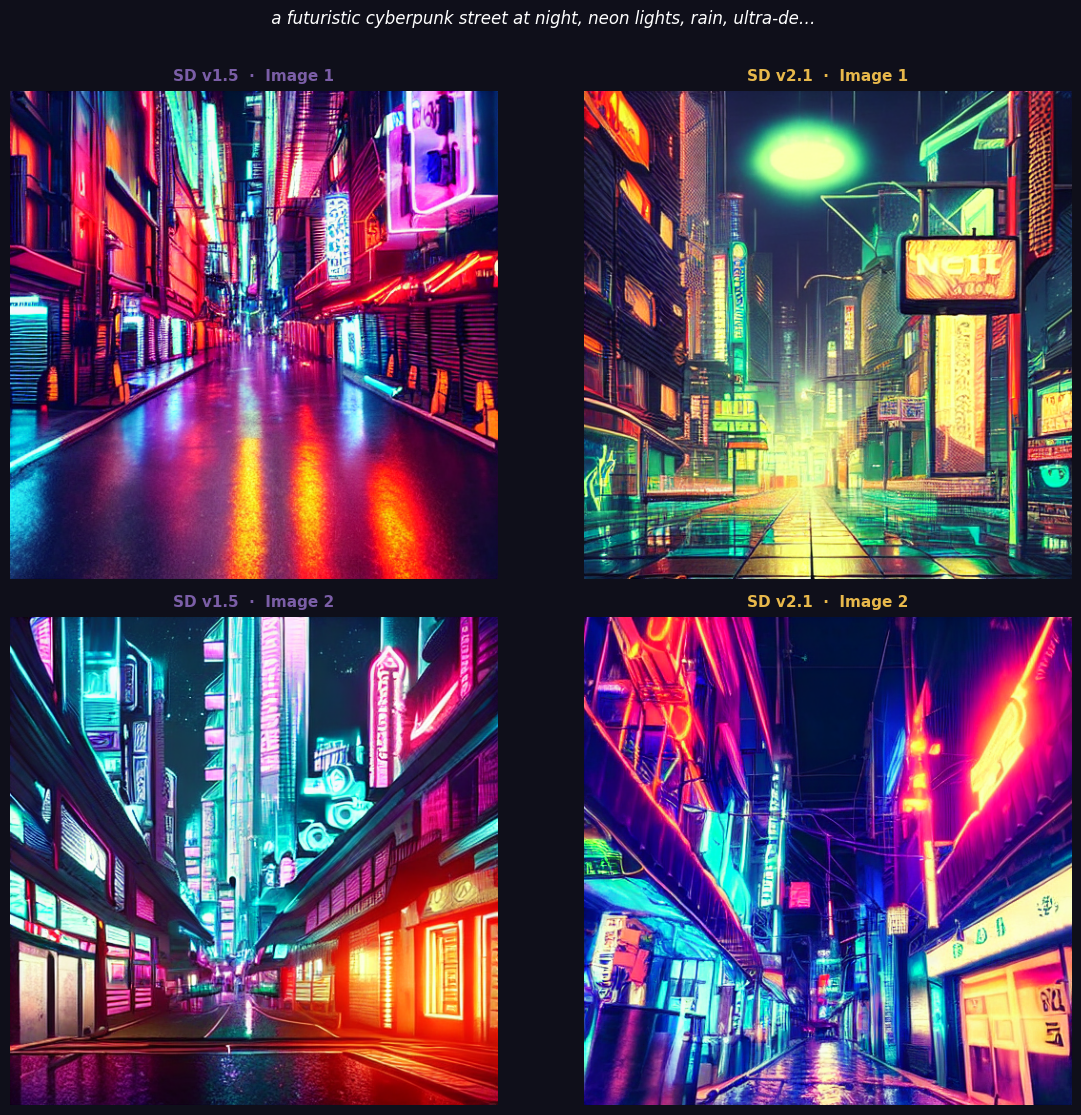

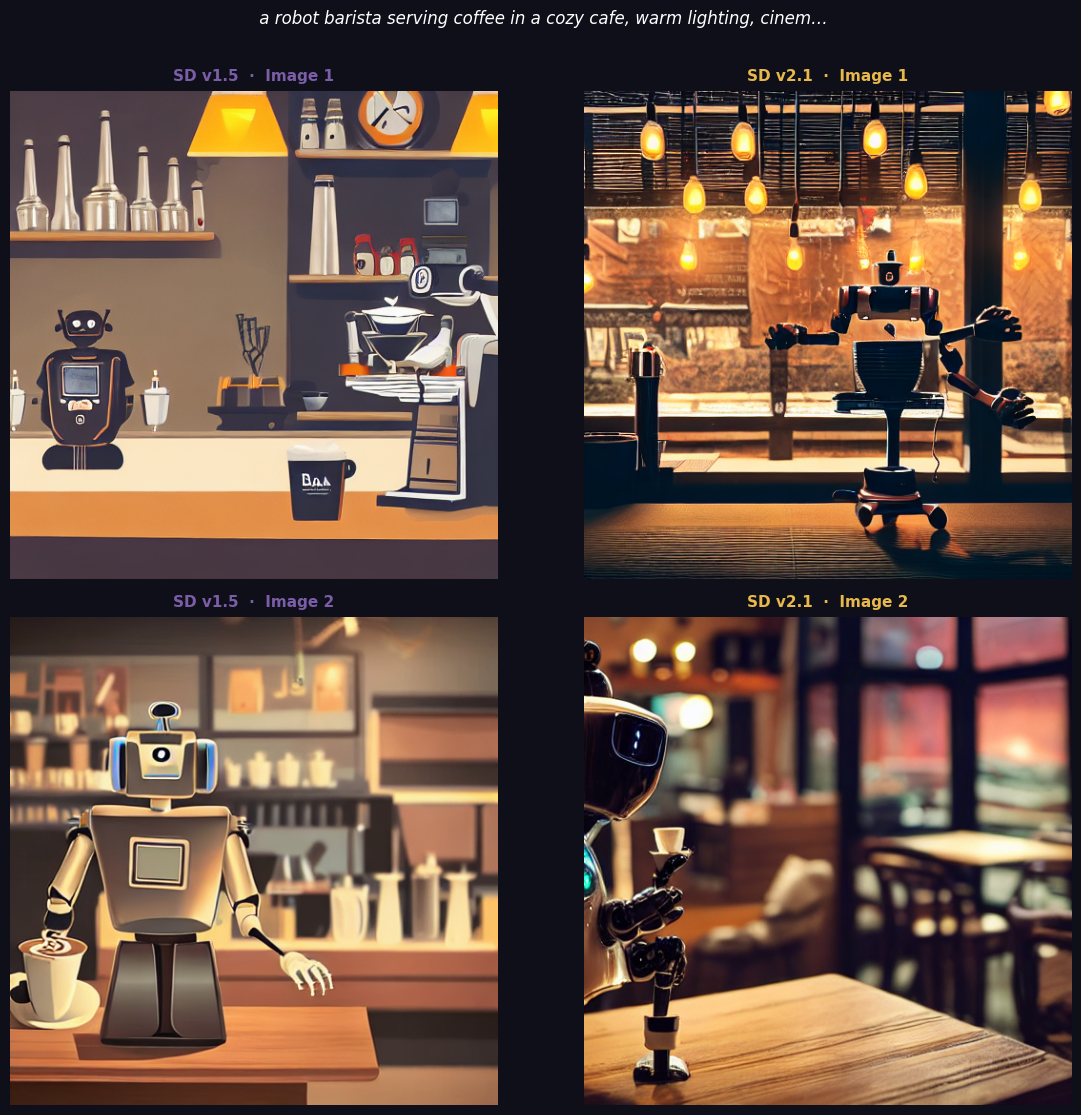

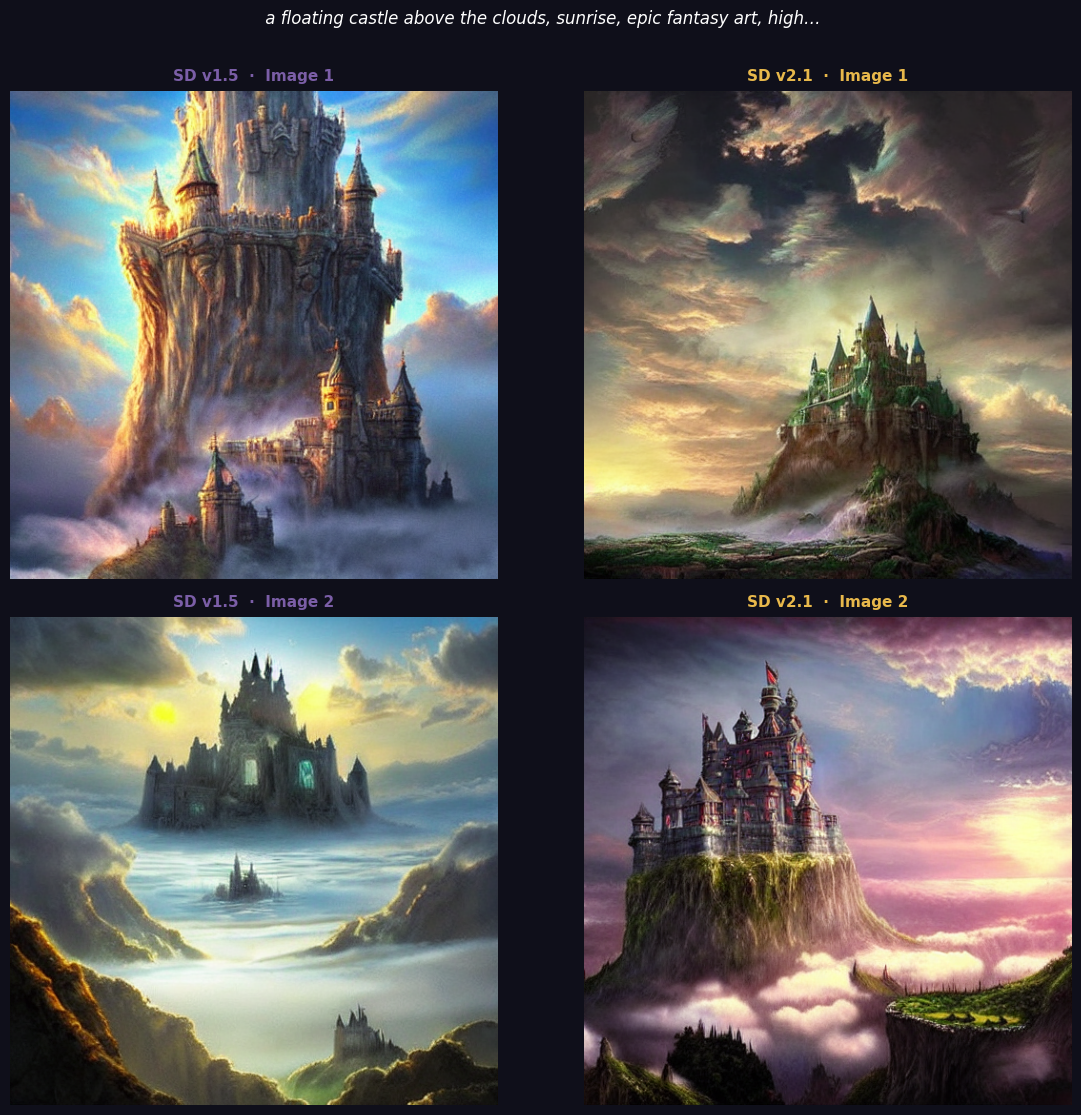

In [10]:
#6) Visual Comparison Grids
COLOR_A = '#7B5EA7'
COLOR_B = '#E8B84B'

def show_comparison(prompt, paths_a, paths_b):
    fig, axes = plt.subplots(2, 2, figsize=(12, 11))
    fig.patch.set_facecolor('#0f0f1a')

    pairs = [
        (paths_a[0], 'SD v1.5  ·  Image 1', COLOR_A),
        (paths_b[0], 'SD v2.1  ·  Image 1', COLOR_B),
        (paths_a[1], 'SD v1.5  ·  Image 2', COLOR_A),
        (paths_b[1], 'SD v2.1  ·  Image 2', COLOR_B),
    ]

    for ax, (path, title, color) in zip(axes.flat, pairs):
        ax.imshow(np.array(Image.open(path)))
        ax.axis('off')
        ax.set_title(title, color=color, fontsize=11, fontweight='bold', pad=8)
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
            spine.set_visible(True)

    short = prompt if len(prompt) < 70 else prompt[:67] + '…'
    fig.suptitle(f' {short}', color='white', fontsize=12, y=1.01, style='italic')
    plt.tight_layout()
    plt.show()

for prompt in PROMPTS:
    show_comparison(prompt, results_A[prompt], results_B[prompt])

In [11]:
#7) CLIP Similarity Scoring
print('Loading CLIP ViT-B/32 …')
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='openai'
)
clip_model = clip_model.to(DEVICE).eval()
clip_tok   = open_clip.get_tokenizer('ViT-B-32')
print('CLIP ready')

@torch.no_grad()
def clip_score(prompt, image_path):
    img    = clip_preprocess(Image.open(image_path).convert('RGB')).unsqueeze(0).to(DEVICE)
    txt    = clip_tok([prompt]).to(DEVICE)
    i_feat = clip_model.encode_image(img)
    t_feat = clip_model.encode_text(txt)
    i_feat /= i_feat.norm(dim=-1, keepdim=True)
    t_feat /= t_feat.norm(dim=-1, keepdim=True)
    return (i_feat * t_feat).sum().item()

clip_scores_A = {}
clip_scores_B = {}

for prompt in PROMPTS:
    clip_scores_A[prompt] = [clip_score(prompt, p) for p in results_A[prompt]]
    clip_scores_B[prompt] = [clip_score(prompt, p) for p in results_B[prompt]]
    print(f'\nPrompt: "{prompt[:55]}…"')
    print(f'  SD v1.5 scores : {[f"{s:.4f}" for s in clip_scores_A[prompt]]}  avg={np.mean(clip_scores_A[prompt]):.4f}')
    print(f'  SD v2.1 scores : {[f"{s:.4f}" for s in clip_scores_B[prompt]]}  avg={np.mean(clip_scores_B[prompt]):.4f}')

Loading CLIP ViT-B/32 …


100%|████████████████████████████████████████| 354M/354M [00:01<00:00, 268MiB/s]


CLIP ready

Prompt: "a futuristic cyberpunk street at night, neon lights, ra…"
  SD v1.5 scores : ['0.3364', '0.3401']  avg=0.3382
  SD v2.1 scores : ['0.3363', '0.3238']  avg=0.3301

Prompt: "a robot barista serving coffee in a cozy cafe, warm lig…"
  SD v1.5 scores : ['0.3632', '0.3612']  avg=0.3622
  SD v2.1 scores : ['0.3841', '0.3528']  avg=0.3685

Prompt: "a floating castle above the clouds, sunrise, epic fanta…"
  SD v1.5 scores : ['0.3597', '0.3404']  avg=0.3500
  SD v2.1 scores : ['0.3475', '0.3496']  avg=0.3486


In [12]:
#8)  Results Tables
def print_table(rows, headers):
    widths = [len(h) for h in headers]
    for r in rows:
        for i, c in enumerate(r):
            widths[i] = max(widths[i], len(str(c)))
    sep = '-+-'.join('-' * w for w in widths)
    print(' | '.join(str(h).ljust(widths[i]) for i, h in enumerate(headers)))
    print(sep)
    for r in rows:
        print(' | '.join(str(c).ljust(widths[i]) for i, c in enumerate(r)))

# Detailed table
print('\n DETAILED CLIP SCORES\n')
detail_rows = []
for prompt in PROMPTS:
    short = prompt[:48] + '…' if len(prompt) > 48 else prompt
    for i, s in enumerate(clip_scores_A[prompt], 1):
        detail_rows.append([short, 'SD v1.5', i, f'{s:.4f}', f'{times_A[prompt]:.1f}s'])
    for i, s in enumerate(clip_scores_B[prompt], 1):
        detail_rows.append([short, 'SD v2.1', i, f'{s:.4f}', f'{times_B[prompt]:.1f}s'])
print_table(detail_rows, ['Prompt', 'Model', 'Img#', 'CLIP Score', 'Time'])

# Summary table
print('\n\n SUMMARY\n')
summary_rows = []
for prompt in PROMPTS:
    short  = prompt[:48] + '…' if len(prompt) > 48 else prompt
    avg_a  = np.mean(clip_scores_A[prompt])
    avg_b  = np.mean(clip_scores_B[prompt])
    winner = 'SD v1.5 ✓' if avg_a >= avg_b else 'SD v2.1 ✓'
    summary_rows.append([short, f'{avg_a:.4f}', f'{times_A[prompt]:.1f}s',
                                 f'{avg_b:.4f}', f'{times_B[prompt]:.1f}s', winner])
print_table(summary_rows, ['Prompt', 'A AvgCLIP', 'A Time', 'B AvgCLIP', 'B Time', 'Winner'])


 DETAILED CLIP SCORES

Prompt                                            | Model   | Img# | CLIP Score | Time
--------------------------------------------------+---------+------+------------+-----
a futuristic cyberpunk street at night, neon lig… | SD v1.5 | 1    | 0.3364     | 9.5s
a futuristic cyberpunk street at night, neon lig… | SD v1.5 | 2    | 0.3401     | 9.5s
a futuristic cyberpunk street at night, neon lig… | SD v2.1 | 1    | 0.3363     | 7.9s
a futuristic cyberpunk street at night, neon lig… | SD v2.1 | 2    | 0.3238     | 7.9s
a robot barista serving coffee in a cozy cafe, w… | SD v1.5 | 1    | 0.3632     | 7.8s
a robot barista serving coffee in a cozy cafe, w… | SD v1.5 | 2    | 0.3612     | 7.8s
a robot barista serving coffee in a cozy cafe, w… | SD v2.1 | 1    | 0.3841     | 7.8s
a robot barista serving coffee in a cozy cafe, w… | SD v2.1 | 2    | 0.3528     | 7.8s
a floating castle above the clouds, sunrise, epi… | SD v1.5 | 1    | 0.3597     | 7.9s
a floating castle a

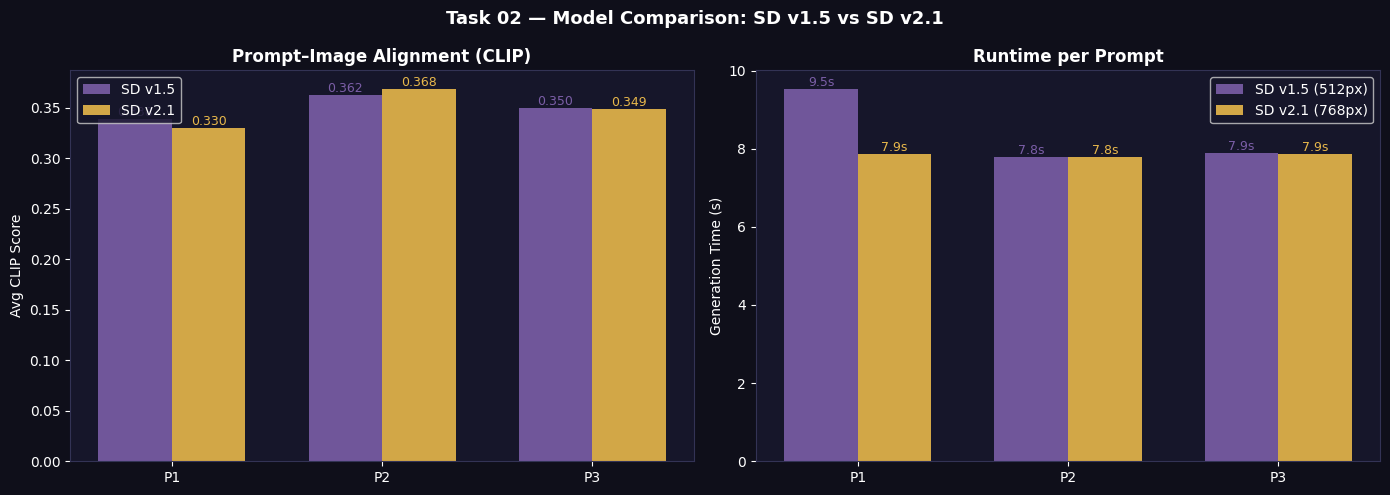

Chart saved → task02_comparison_chart.png


In [13]:
#9) Bar Charts
labels      = [f'P{i+1}' for i in range(len(PROMPTS))]
avgs_a      = [np.mean(clip_scores_A[p]) for p in PROMPTS]
avgs_b      = [np.mean(clip_scores_B[p]) for p in PROMPTS]
times_a_lst = [times_A[p] for p in PROMPTS]
times_b_lst = [times_B[p] for p in PROMPTS]

x, w = np.arange(len(labels)), 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#0f0f1a')

for ax in (ax1, ax2):
    ax.set_facecolor('#16162a')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('#333355')

# CLIP chart
b1 = ax1.bar(x - w/2, avgs_a, w, label='SD v1.5', color='#7B5EA7', alpha=0.9)
b2 = ax1.bar(x + w/2, avgs_b, w, label='SD v2.1', color='#E8B84B', alpha=0.9)
ax1.set_xticks(x); ax1.set_xticklabels(labels, color='white')
ax1.set_ylabel('Avg CLIP Score', color='white')
ax1.set_title('Prompt–Image Alignment (CLIP)', color='white', fontweight='bold')
ax1.legend(facecolor='#16162a', labelcolor='white')
ax1.bar_label(b1, fmt='%.3f', color='#7B5EA7', fontsize=9)
ax1.bar_label(b2, fmt='%.3f', color='#E8B84B', fontsize=9)

# Runtime chart
b3 = ax2.bar(x - w/2, times_a_lst, w, label='SD v1.5 (512px)', color='#7B5EA7', alpha=0.9)
b4 = ax2.bar(x + w/2, times_b_lst, w, label='SD v2.1 (768px)', color='#E8B84B', alpha=0.9)
ax2.set_xticks(x); ax2.set_xticklabels(labels, color='white')
ax2.set_ylabel('Generation Time (s)', color='white')
ax2.set_title('Runtime per Prompt', color='white', fontweight='bold')
ax2.legend(facecolor='#16162a', labelcolor='white')
ax2.bar_label(b3, fmt='%.1fs', color='#7B5EA7', fontsize=9)
ax2.bar_label(b4, fmt='%.1fs', color='#E8B84B', fontsize=9)

plt.suptitle('Task 02 — Model Comparison: SD v1.5 vs SD v2.1',
             color='white', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('task02_comparison_chart.png', dpi=150, bbox_inches='tight', facecolor='#0f0f1a')
plt.show()
print('Chart saved → task02_comparison_chart.png')